In [124]:
import glob
import json
import os, pathlib
import random
import time
from collections import defaultdict
import sys

In [125]:
import numpy as np
import jax
import jax.numpy as jnp
import tqdm
import wandb
import matplotlib.pyplot as plt

In [126]:
import sys
sys.path.insert(0, "../")

In [127]:
%env PYTHONPATH=../:${PYTHONPATH}
from agents import agents
from utils.datasets import Dataset, GCDataset, HGCDataset, ReplayBuffer
from utils.plot_utils import plot_data

env: PYTHONPATH=../:${PYTHONPATH}


In [128]:
env_name = 'humanoidmaze-medium-navigate-oraclerep-v0'
dataset_dir = '../../scratch/data/humanoidmaze-medium-navigate-v0'
datasets = [file for file in sorted(glob.glob(f'{dataset_dir}/*.npz')) if '-val.npz' not in file]
dataset_idx = 0
dataset_path = datasets[dataset_idx]

In [129]:
from wrappers.datafuncs_utils import make_env_and_datasets
env, train_dataset, val_dataset = make_env_and_datasets(env_name, dataset_path=str(dataset_path), use_oracle_reps=True)

In [130]:
from wrappers.datafuncs_utils import clip_dataset
N = int(1000000)
train_dataset = clip_dataset(train_dataset, N)
random.seed(0)
np.random.seed(0)

In [131]:
from agents.gcfql import get_config
config = get_config()

config['alpha'] = 300
config['actor_type'] = 'best-of-n'
config['train_goal_proposer'] = True
config['actor_hidden_dims'] = (512, 512, 512, 512)
config['value_hidden_dims'] = (512, 512, 512, 512)
config['batch_size'] = 256
config['num_actions'] = 8
config['num_qs'] = 10
config['q_agg'] = 'mean'
config['subgoal_steps'] = 50
config['goal_propser_type'] = 'actor-gc'
config['discount'] = 0.995

In [132]:
train_dataset = GCDataset(Dataset.create(**train_dataset, freeze=False), config)
val_dataset = GCDataset(Dataset.create(**val_dataset, freeze=True), config)

In [133]:
from agents.rnd import RND
import ml_collections

rnd_config = ml_collections.ConfigDict(
            dict(
                agent_name='rnd',
                lr=1e-4,
                coeff=1.0,
                hidden_dims=(512, 512, 512),
            )
        )

In [134]:
observation_example = train_dataset.dataset['oracle_reps'][0]
action_example = train_dataset.dataset['actions'][0]
rnd = RND.create(0, observation_example=observation_example, action_example=action_example, config=rnd_config)

In [135]:
train_dataset.dataset['oracle_reps'][0, :]

array([3.593619 , 7.3534546], dtype=float32)

In [136]:
for i in tqdm.tqdm(range(0, train_dataset.size, 100)):
    rnd, rnd_info = rnd.update(
        batch={
            'observations': train_dataset.dataset['oracle_reps'][i:i + 100, :],
            'actions': None,
        }
    )

    if i % 1000 == 0:
        print(rnd_info)

  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 120/10000 [00:00<00:37, 264.59it/s]

{'rnd_loss': Array(0.1465017, dtype=float32)}
{'rnd_loss': Array(0.18681423, dtype=float32)}
{'rnd_loss': Array(0.28362453, dtype=float32)}
{'rnd_loss': Array(0.15835926, dtype=float32)}
{'rnd_loss': Array(0.00555247, dtype=float32)}
{'rnd_loss': Array(0.02256665, dtype=float32)}
{'rnd_loss': Array(0.00830531, dtype=float32)}
{'rnd_loss': Array(0.04639919, dtype=float32)}
{'rnd_loss': Array(0.01185485, dtype=float32)}
{'rnd_loss': Array(0.00130803, dtype=float32)}
{'rnd_loss': Array(0.00140775, dtype=float32)}
{'rnd_loss': Array(0.04918308, dtype=float32)}
{'rnd_loss': Array(0.00240037, dtype=float32)}
{'rnd_loss': Array(0.00067507, dtype=float32)}
{'rnd_loss': Array(0.0460753, dtype=float32)}
{'rnd_loss': Array(0.00778646, dtype=float32)}
{'rnd_loss': Array(0.0940261, dtype=float32)}
{'rnd_loss': Array(0.00376821, dtype=float32)}
{'rnd_loss': Array(0.01426071, dtype=float32)}
{'rnd_loss': Array(0.0246063, dtype=float32)}
{'rnd_loss': Array(0.00321721, dtype=float32)}
{'rnd_loss': Arra

  5%|▍         | 462/10000 [00:00<00:12, 763.13it/s]

{'rnd_loss': Array(0.00094835, dtype=float32)}
{'rnd_loss': Array(0.005415, dtype=float32)}
{'rnd_loss': Array(0.00161177, dtype=float32)}
{'rnd_loss': Array(0.03529476, dtype=float32)}
{'rnd_loss': Array(0.00194695, dtype=float32)}
{'rnd_loss': Array(0.00142155, dtype=float32)}
{'rnd_loss': Array(0.00106044, dtype=float32)}
{'rnd_loss': Array(0.0079215, dtype=float32)}
{'rnd_loss': Array(0.00092517, dtype=float32)}
{'rnd_loss': Array(0.00107255, dtype=float32)}
{'rnd_loss': Array(0.00034385, dtype=float32)}
{'rnd_loss': Array(0.00022897, dtype=float32)}
{'rnd_loss': Array(0.00033002, dtype=float32)}
{'rnd_loss': Array(0.00606306, dtype=float32)}
{'rnd_loss': Array(0.00322052, dtype=float32)}
{'rnd_loss': Array(0.00349281, dtype=float32)}
{'rnd_loss': Array(0.01610278, dtype=float32)}
{'rnd_loss': Array(0.00307118, dtype=float32)}
{'rnd_loss': Array(0.00383272, dtype=float32)}
{'rnd_loss': Array(0.00737381, dtype=float32)}
{'rnd_loss': Array(0.00293452, dtype=float32)}
{'rnd_loss': Arr

  7%|▋         | 680/10000 [00:01<00:10, 895.93it/s]

{'rnd_loss': Array(0.00231838, dtype=float32)}
{'rnd_loss': Array(0.00446902, dtype=float32)}
{'rnd_loss': Array(0.00333805, dtype=float32)}
{'rnd_loss': Array(0.00012693, dtype=float32)}
{'rnd_loss': Array(0.00264515, dtype=float32)}
{'rnd_loss': Array(0.00394572, dtype=float32)}
{'rnd_loss': Array(0.00328938, dtype=float32)}
{'rnd_loss': Array(0.00589648, dtype=float32)}
{'rnd_loss': Array(0.00266454, dtype=float32)}
{'rnd_loss': Array(0.000421, dtype=float32)}
{'rnd_loss': Array(0.00175395, dtype=float32)}
{'rnd_loss': Array(0.00144236, dtype=float32)}
{'rnd_loss': Array(0.00101113, dtype=float32)}
{'rnd_loss': Array(0.00026293, dtype=float32)}
{'rnd_loss': Array(0.00063293, dtype=float32)}
{'rnd_loss': Array(0.00087751, dtype=float32)}
{'rnd_loss': Array(0.0010393, dtype=float32)}
{'rnd_loss': Array(0.00239514, dtype=float32)}
{'rnd_loss': Array(0.00118923, dtype=float32)}
{'rnd_loss': Array(0.00171442, dtype=float32)}
{'rnd_loss': Array(0.00012766, dtype=float32)}
{'rnd_loss': Arr

  9%|▉         | 897/10000 [00:01<00:09, 978.80it/s]

{'rnd_loss': Array(0.00081681, dtype=float32)}
{'rnd_loss': Array(0.00181788, dtype=float32)}
{'rnd_loss': Array(0.00046447, dtype=float32)}
{'rnd_loss': Array(0.00076015, dtype=float32)}
{'rnd_loss': Array(0.00046165, dtype=float32)}
{'rnd_loss': Array(0.0060703, dtype=float32)}
{'rnd_loss': Array(0.00119889, dtype=float32)}
{'rnd_loss': Array(0.00097776, dtype=float32)}
{'rnd_loss': Array(0.00057031, dtype=float32)}
{'rnd_loss': Array(0.00164104, dtype=float32)}
{'rnd_loss': Array(0.00039536, dtype=float32)}
{'rnd_loss': Array(9.6938646e-05, dtype=float32)}
{'rnd_loss': Array(0.00037364, dtype=float32)}
{'rnd_loss': Array(0.00065708, dtype=float32)}
{'rnd_loss': Array(0.00087979, dtype=float32)}
{'rnd_loss': Array(0.00319492, dtype=float32)}
{'rnd_loss': Array(0.00047291, dtype=float32)}
{'rnd_loss': Array(0.00146677, dtype=float32)}
{'rnd_loss': Array(0.00055512, dtype=float32)}
{'rnd_loss': Array(0.00022021, dtype=float32)}
{'rnd_loss': Array(0.00052714, dtype=float32)}
{'rnd_loss'

 11%|█▏        | 1132/10000 [00:01<00:08, 1073.57it/s]

{'rnd_loss': Array(0.00044686, dtype=float32)}
{'rnd_loss': Array(0.00010654, dtype=float32)}
{'rnd_loss': Array(0.00073403, dtype=float32)}
{'rnd_loss': Array(0.00084339, dtype=float32)}
{'rnd_loss': Array(0.00035586, dtype=float32)}
{'rnd_loss': Array(0.00045103, dtype=float32)}
{'rnd_loss': Array(0.00106156, dtype=float32)}
{'rnd_loss': Array(0.00017623, dtype=float32)}
{'rnd_loss': Array(0.00054633, dtype=float32)}
{'rnd_loss': Array(0.00099351, dtype=float32)}
{'rnd_loss': Array(0.0004623, dtype=float32)}
{'rnd_loss': Array(0.00111312, dtype=float32)}
{'rnd_loss': Array(0.0007105, dtype=float32)}
{'rnd_loss': Array(0.00071788, dtype=float32)}
{'rnd_loss': Array(0.00041929, dtype=float32)}
{'rnd_loss': Array(5.584335e-05, dtype=float32)}
{'rnd_loss': Array(0.00041755, dtype=float32)}
{'rnd_loss': Array(0.00013162, dtype=float32)}
{'rnd_loss': Array(0.00059768, dtype=float32)}
{'rnd_loss': Array(0.00158161, dtype=float32)}
{'rnd_loss': Array(0.00051348, dtype=float32)}
{'rnd_loss': 

 14%|█▎        | 1358/10000 [00:01<00:07, 1087.93it/s]

{'rnd_loss': Array(0.00012159, dtype=float32)}
{'rnd_loss': Array(0.0005486, dtype=float32)}
{'rnd_loss': Array(0.00072025, dtype=float32)}
{'rnd_loss': Array(0.00061637, dtype=float32)}
{'rnd_loss': Array(0.00067473, dtype=float32)}
{'rnd_loss': Array(0.00088142, dtype=float32)}
{'rnd_loss': Array(0.00032152, dtype=float32)}
{'rnd_loss': Array(0.00084381, dtype=float32)}
{'rnd_loss': Array(0.00022794, dtype=float32)}
{'rnd_loss': Array(0.00030211, dtype=float32)}
{'rnd_loss': Array(0.00126835, dtype=float32)}
{'rnd_loss': Array(0.00096255, dtype=float32)}
{'rnd_loss': Array(0.00062139, dtype=float32)}
{'rnd_loss': Array(0.00225326, dtype=float32)}
{'rnd_loss': Array(0.00124365, dtype=float32)}
{'rnd_loss': Array(0.00299024, dtype=float32)}
{'rnd_loss': Array(0.00040658, dtype=float32)}
{'rnd_loss': Array(0.00147803, dtype=float32)}
{'rnd_loss': Array(0.00091407, dtype=float32)}
{'rnd_loss': Array(0.00096492, dtype=float32)}
{'rnd_loss': Array(0.00292165, dtype=float32)}
{'rnd_loss': A

 16%|█▌        | 1579/10000 [00:01<00:07, 1078.63it/s]

{'rnd_loss': Array(0.00293106, dtype=float32)}
{'rnd_loss': Array(0.00111766, dtype=float32)}
{'rnd_loss': Array(0.0023548, dtype=float32)}
{'rnd_loss': Array(0.00238536, dtype=float32)}
{'rnd_loss': Array(9.665026e-05, dtype=float32)}
{'rnd_loss': Array(0.00127523, dtype=float32)}
{'rnd_loss': Array(0.00382119, dtype=float32)}
{'rnd_loss': Array(0.00142265, dtype=float32)}
{'rnd_loss': Array(0.00294381, dtype=float32)}
{'rnd_loss': Array(0.00121448, dtype=float32)}
{'rnd_loss': Array(0.00182223, dtype=float32)}
{'rnd_loss': Array(0.00236731, dtype=float32)}
{'rnd_loss': Array(0.00041448, dtype=float32)}
{'rnd_loss': Array(0.00148705, dtype=float32)}
{'rnd_loss': Array(0.00103798, dtype=float32)}
{'rnd_loss': Array(0.00021989, dtype=float32)}
{'rnd_loss': Array(0.00020639, dtype=float32)}
{'rnd_loss': Array(3.5835674e-05, dtype=float32)}
{'rnd_loss': Array(0.00073806, dtype=float32)}
{'rnd_loss': Array(0.00024738, dtype=float32)}
{'rnd_loss': Array(0.00023266, dtype=float32)}
{'rnd_los

 18%|█▊        | 1806/10000 [00:02<00:07, 1099.94it/s]

{'rnd_loss': Array(0.00026503, dtype=float32)}
{'rnd_loss': Array(0.00013196, dtype=float32)}
{'rnd_loss': Array(0.0010248, dtype=float32)}
{'rnd_loss': Array(0.00044488, dtype=float32)}
{'rnd_loss': Array(8.773059e-05, dtype=float32)}
{'rnd_loss': Array(0.00017962, dtype=float32)}
{'rnd_loss': Array(0.00125952, dtype=float32)}
{'rnd_loss': Array(7.200875e-05, dtype=float32)}
{'rnd_loss': Array(0.00045647, dtype=float32)}
{'rnd_loss': Array(0.00040477, dtype=float32)}
{'rnd_loss': Array(0.00063087, dtype=float32)}
{'rnd_loss': Array(0.00037697, dtype=float32)}
{'rnd_loss': Array(0.00039121, dtype=float32)}
{'rnd_loss': Array(0.00078776, dtype=float32)}
{'rnd_loss': Array(0.00123696, dtype=float32)}
{'rnd_loss': Array(0.00031614, dtype=float32)}
{'rnd_loss': Array(0.00013589, dtype=float32)}
{'rnd_loss': Array(0.00032623, dtype=float32)}
{'rnd_loss': Array(0.0011155, dtype=float32)}
{'rnd_loss': Array(0.00030935, dtype=float32)}
{'rnd_loss': Array(0.0004557, dtype=float32)}
{'rnd_loss':

 20%|██        | 2035/10000 [00:02<00:07, 1120.26it/s]

{'rnd_loss': Array(0.00076909, dtype=float32)}
{'rnd_loss': Array(0.00039784, dtype=float32)}
{'rnd_loss': Array(0.00096438, dtype=float32)}
{'rnd_loss': Array(0.00022994, dtype=float32)}
{'rnd_loss': Array(0.00108289, dtype=float32)}
{'rnd_loss': Array(0.00063455, dtype=float32)}
{'rnd_loss': Array(0.00016403, dtype=float32)}
{'rnd_loss': Array(0.00022143, dtype=float32)}
{'rnd_loss': Array(0.00022443, dtype=float32)}
{'rnd_loss': Array(0.00035236, dtype=float32)}
{'rnd_loss': Array(0.00062466, dtype=float32)}
{'rnd_loss': Array(0.0002346, dtype=float32)}
{'rnd_loss': Array(0.00016225, dtype=float32)}
{'rnd_loss': Array(0.00017963, dtype=float32)}
{'rnd_loss': Array(0.00191587, dtype=float32)}
{'rnd_loss': Array(0.00049943, dtype=float32)}
{'rnd_loss': Array(0.00053174, dtype=float32)}
{'rnd_loss': Array(0.00029479, dtype=float32)}
{'rnd_loss': Array(0.00047552, dtype=float32)}
{'rnd_loss': Array(0.00099648, dtype=float32)}
{'rnd_loss': Array(0.00023468, dtype=float32)}
{'rnd_loss': A

 23%|██▎       | 2262/10000 [00:02<00:06, 1107.82it/s]

{'rnd_loss': Array(0.00060383, dtype=float32)}
{'rnd_loss': Array(4.692251e-05, dtype=float32)}
{'rnd_loss': Array(0.00039175, dtype=float32)}
{'rnd_loss': Array(0.0002971, dtype=float32)}
{'rnd_loss': Array(0.00023616, dtype=float32)}
{'rnd_loss': Array(0.0005593, dtype=float32)}
{'rnd_loss': Array(0.00042864, dtype=float32)}
{'rnd_loss': Array(6.001085e-05, dtype=float32)}
{'rnd_loss': Array(0.00048519, dtype=float32)}
{'rnd_loss': Array(0.00154837, dtype=float32)}
{'rnd_loss': Array(0.00045584, dtype=float32)}
{'rnd_loss': Array(0.00038143, dtype=float32)}
{'rnd_loss': Array(0.00020738, dtype=float32)}
{'rnd_loss': Array(0.00055689, dtype=float32)}
{'rnd_loss': Array(0.00014963, dtype=float32)}
{'rnd_loss': Array(5.990356e-05, dtype=float32)}
{'rnd_loss': Array(0.00011807, dtype=float32)}
{'rnd_loss': Array(0.00070491, dtype=float32)}
{'rnd_loss': Array(0.00029508, dtype=float32)}
{'rnd_loss': Array(0.00063227, dtype=float32)}
{'rnd_loss': Array(0.00014887, dtype=float32)}
{'rnd_los

 25%|██▍       | 2499/10000 [00:02<00:06, 1147.32it/s]

{'rnd_loss': Array(0.0005217, dtype=float32)}
{'rnd_loss': Array(0.00037616, dtype=float32)}
{'rnd_loss': Array(0.00019526, dtype=float32)}
{'rnd_loss': Array(0.00034452, dtype=float32)}
{'rnd_loss': Array(0.00019865, dtype=float32)}
{'rnd_loss': Array(0.00025832, dtype=float32)}
{'rnd_loss': Array(0.00063543, dtype=float32)}
{'rnd_loss': Array(0.00043195, dtype=float32)}
{'rnd_loss': Array(0.00059606, dtype=float32)}
{'rnd_loss': Array(4.1019346e-05, dtype=float32)}
{'rnd_loss': Array(3.6853417e-05, dtype=float32)}
{'rnd_loss': Array(0.00032873, dtype=float32)}
{'rnd_loss': Array(0.00051516, dtype=float32)}
{'rnd_loss': Array(0.00055673, dtype=float32)}
{'rnd_loss': Array(0.00052567, dtype=float32)}
{'rnd_loss': Array(0.00054383, dtype=float32)}
{'rnd_loss': Array(0.00025019, dtype=float32)}
{'rnd_loss': Array(0.00051899, dtype=float32)}
{'rnd_loss': Array(0.00087282, dtype=float32)}
{'rnd_loss': Array(0.00030799, dtype=float32)}
{'rnd_loss': Array(0.00711165, dtype=float32)}
{'rnd_lo

 27%|██▋       | 2743/10000 [00:02<00:06, 1183.29it/s]

{'rnd_loss': Array(0.00014787, dtype=float32)}
{'rnd_loss': Array(0.00140045, dtype=float32)}
{'rnd_loss': Array(0.00174218, dtype=float32)}
{'rnd_loss': Array(0.00068398, dtype=float32)}
{'rnd_loss': Array(0.00333066, dtype=float32)}
{'rnd_loss': Array(0.00052736, dtype=float32)}
{'rnd_loss': Array(0.0007593, dtype=float32)}
{'rnd_loss': Array(0.00041985, dtype=float32)}
{'rnd_loss': Array(0.00068605, dtype=float32)}
{'rnd_loss': Array(0.00012716, dtype=float32)}
{'rnd_loss': Array(0.00141645, dtype=float32)}
{'rnd_loss': Array(0.00017128, dtype=float32)}
{'rnd_loss': Array(0.00100691, dtype=float32)}
{'rnd_loss': Array(0.00025054, dtype=float32)}
{'rnd_loss': Array(0.00012661, dtype=float32)}
{'rnd_loss': Array(0.0001829, dtype=float32)}
{'rnd_loss': Array(8.37401e-05, dtype=float32)}
{'rnd_loss': Array(9.7914286e-05, dtype=float32)}
{'rnd_loss': Array(9.4351235e-05, dtype=float32)}
{'rnd_loss': Array(0.00036118, dtype=float32)}
{'rnd_loss': Array(0.00017975, dtype=float32)}
{'rnd_lo

 30%|██▉       | 2986/10000 [00:03<00:05, 1192.93it/s]

{'rnd_loss': Array(0.0001471, dtype=float32)}
{'rnd_loss': Array(0.00017306, dtype=float32)}
{'rnd_loss': Array(0.00016572, dtype=float32)}
{'rnd_loss': Array(0.00015527, dtype=float32)}
{'rnd_loss': Array(0.00037081, dtype=float32)}
{'rnd_loss': Array(5.1457824e-05, dtype=float32)}
{'rnd_loss': Array(9.9476536e-05, dtype=float32)}
{'rnd_loss': Array(0.00038357, dtype=float32)}
{'rnd_loss': Array(8.142138e-05, dtype=float32)}
{'rnd_loss': Array(1.733536e-05, dtype=float32)}
{'rnd_loss': Array(0.00177876, dtype=float32)}
{'rnd_loss': Array(0.00013493, dtype=float32)}
{'rnd_loss': Array(0.00096487, dtype=float32)}
{'rnd_loss': Array(0.00015289, dtype=float32)}
{'rnd_loss': Array(0.00078316, dtype=float32)}
{'rnd_loss': Array(0.00013291, dtype=float32)}
{'rnd_loss': Array(3.551501e-05, dtype=float32)}
{'rnd_loss': Array(0.00014449, dtype=float32)}
{'rnd_loss': Array(0.00072256, dtype=float32)}
{'rnd_loss': Array(0.00049252, dtype=float32)}
{'rnd_loss': Array(6.597527e-05, dtype=float32)}


 32%|███▏      | 3236/10000 [00:03<00:05, 1218.71it/s]

{'rnd_loss': Array(0.00042148, dtype=float32)}
{'rnd_loss': Array(0.00041542, dtype=float32)}
{'rnd_loss': Array(3.101063e-05, dtype=float32)}
{'rnd_loss': Array(0.001393, dtype=float32)}
{'rnd_loss': Array(0.00049356, dtype=float32)}
{'rnd_loss': Array(0.00063887, dtype=float32)}
{'rnd_loss': Array(4.6151094e-05, dtype=float32)}
{'rnd_loss': Array(5.0089133e-05, dtype=float32)}
{'rnd_loss': Array(0.00057159, dtype=float32)}
{'rnd_loss': Array(0.0005763, dtype=float32)}
{'rnd_loss': Array(0.00176067, dtype=float32)}
{'rnd_loss': Array(0.00075941, dtype=float32)}
{'rnd_loss': Array(4.8920603e-05, dtype=float32)}
{'rnd_loss': Array(0.00220612, dtype=float32)}
{'rnd_loss': Array(0.00062658, dtype=float32)}
{'rnd_loss': Array(0.00079962, dtype=float32)}
{'rnd_loss': Array(0.00024204, dtype=float32)}
{'rnd_loss': Array(0.00145059, dtype=float32)}
{'rnd_loss': Array(0.00050844, dtype=float32)}
{'rnd_loss': Array(0.00022438, dtype=float32)}
{'rnd_loss': Array(0.00156871, dtype=float32)}
{'rnd

 35%|███▍      | 3485/10000 [00:03<00:05, 1228.09it/s]

{'rnd_loss': Array(0.00021114, dtype=float32)}
{'rnd_loss': Array(0.00126434, dtype=float32)}
{'rnd_loss': Array(0.00115093, dtype=float32)}
{'rnd_loss': Array(0.0003454, dtype=float32)}
{'rnd_loss': Array(0.0003844, dtype=float32)}
{'rnd_loss': Array(0.00041627, dtype=float32)}
{'rnd_loss': Array(0.0012965, dtype=float32)}
{'rnd_loss': Array(0.00404264, dtype=float32)}
{'rnd_loss': Array(0.00084885, dtype=float32)}
{'rnd_loss': Array(0.0001932, dtype=float32)}
{'rnd_loss': Array(0.00159342, dtype=float32)}
{'rnd_loss': Array(8.027758e-05, dtype=float32)}
{'rnd_loss': Array(0.00056739, dtype=float32)}
{'rnd_loss': Array(0.00101619, dtype=float32)}
{'rnd_loss': Array(0.00059095, dtype=float32)}
{'rnd_loss': Array(0.00102905, dtype=float32)}
{'rnd_loss': Array(0.00058057, dtype=float32)}
{'rnd_loss': Array(0.00010409, dtype=float32)}
{'rnd_loss': Array(8.838944e-05, dtype=float32)}
{'rnd_loss': Array(0.00067272, dtype=float32)}
{'rnd_loss': Array(0.00012019, dtype=float32)}
{'rnd_loss': 

 37%|███▋      | 3731/10000 [00:03<00:05, 1216.81it/s]

{'rnd_loss': Array(0.00020482, dtype=float32)}
{'rnd_loss': Array(0.00044114, dtype=float32)}
{'rnd_loss': Array(0.0001348, dtype=float32)}
{'rnd_loss': Array(2.6549247e-05, dtype=float32)}
{'rnd_loss': Array(0.00027208, dtype=float32)}
{'rnd_loss': Array(4.830194e-05, dtype=float32)}
{'rnd_loss': Array(0.0005963, dtype=float32)}
{'rnd_loss': Array(0.00066822, dtype=float32)}
{'rnd_loss': Array(0.00039734, dtype=float32)}
{'rnd_loss': Array(0.00251406, dtype=float32)}
{'rnd_loss': Array(0.00011604, dtype=float32)}
{'rnd_loss': Array(4.0235715e-05, dtype=float32)}
{'rnd_loss': Array(0.00130639, dtype=float32)}
{'rnd_loss': Array(0.00051892, dtype=float32)}
{'rnd_loss': Array(0.00094347, dtype=float32)}
{'rnd_loss': Array(0.00025868, dtype=float32)}
{'rnd_loss': Array(0.00073314, dtype=float32)}
{'rnd_loss': Array(0.00253973, dtype=float32)}
{'rnd_loss': Array(0.00035895, dtype=float32)}
{'rnd_loss': Array(0.00132114, dtype=float32)}
{'rnd_loss': Array(0.00248147, dtype=float32)}
{'rnd_l

 40%|███▉      | 3969/10000 [00:03<00:05, 1148.02it/s]

{'rnd_loss': Array(0.00015621, dtype=float32)}
{'rnd_loss': Array(0.000447, dtype=float32)}
{'rnd_loss': Array(0.00086194, dtype=float32)}
{'rnd_loss': Array(0.00165785, dtype=float32)}
{'rnd_loss': Array(0.00047333, dtype=float32)}
{'rnd_loss': Array(0.00028073, dtype=float32)}
{'rnd_loss': Array(0.00024421, dtype=float32)}
{'rnd_loss': Array(3.9382245e-05, dtype=float32)}
{'rnd_loss': Array(0.00083147, dtype=float32)}
{'rnd_loss': Array(0.00071382, dtype=float32)}
{'rnd_loss': Array(0.00031436, dtype=float32)}
{'rnd_loss': Array(0.00039751, dtype=float32)}
{'rnd_loss': Array(0.00021318, dtype=float32)}
{'rnd_loss': Array(0.00089978, dtype=float32)}
{'rnd_loss': Array(0.00069675, dtype=float32)}
{'rnd_loss': Array(0.00512166, dtype=float32)}
{'rnd_loss': Array(0.00063319, dtype=float32)}
{'rnd_loss': Array(0.00116655, dtype=float32)}
{'rnd_loss': Array(0.00020309, dtype=float32)}
{'rnd_loss': Array(0.00053059, dtype=float32)}
{'rnd_loss': Array(0.001316, dtype=float32)}
{'rnd_loss': A

 42%|████▏     | 4198/10000 [00:04<00:05, 1087.31it/s]

{'rnd_loss': Array(0.0012399, dtype=float32)}
{'rnd_loss': Array(4.9608683e-05, dtype=float32)}
{'rnd_loss': Array(0.00172275, dtype=float32)}
{'rnd_loss': Array(0.00301311, dtype=float32)}
{'rnd_loss': Array(0.00034686, dtype=float32)}
{'rnd_loss': Array(0.00105236, dtype=float32)}
{'rnd_loss': Array(0.00071003, dtype=float32)}
{'rnd_loss': Array(0.00059266, dtype=float32)}
{'rnd_loss': Array(0.00075175, dtype=float32)}
{'rnd_loss': Array(2.5966216e-05, dtype=float32)}
{'rnd_loss': Array(0.00026671, dtype=float32)}
{'rnd_loss': Array(0.00045956, dtype=float32)}
{'rnd_loss': Array(0.00049762, dtype=float32)}
{'rnd_loss': Array(8.797766e-05, dtype=float32)}
{'rnd_loss': Array(0.00026186, dtype=float32)}
{'rnd_loss': Array(0.00024888, dtype=float32)}
{'rnd_loss': Array(0.0002686, dtype=float32)}
{'rnd_loss': Array(0.00016933, dtype=float32)}
{'rnd_loss': Array(0.00026125, dtype=float32)}
{'rnd_loss': Array(0.00093589, dtype=float32)}
{'rnd_loss': Array(0.0001672, dtype=float32)}


 44%|████▍     | 4419/10000 [00:04<00:05, 1081.01it/s]

{'rnd_loss': Array(0.00010276, dtype=float32)}
{'rnd_loss': Array(4.4824294e-05, dtype=float32)}
{'rnd_loss': Array(6.144966e-05, dtype=float32)}
{'rnd_loss': Array(0.00011883, dtype=float32)}
{'rnd_loss': Array(6.590888e-05, dtype=float32)}
{'rnd_loss': Array(5.240797e-05, dtype=float32)}
{'rnd_loss': Array(0.00023563, dtype=float32)}
{'rnd_loss': Array(0.00021686, dtype=float32)}
{'rnd_loss': Array(2.0131756e-05, dtype=float32)}
{'rnd_loss': Array(0.00022072, dtype=float32)}
{'rnd_loss': Array(8.4387655e-05, dtype=float32)}
{'rnd_loss': Array(8.278131e-05, dtype=float32)}
{'rnd_loss': Array(0.00075534, dtype=float32)}
{'rnd_loss': Array(0.00033754, dtype=float32)}
{'rnd_loss': Array(0.0003203, dtype=float32)}
{'rnd_loss': Array(0.00037133, dtype=float32)}
{'rnd_loss': Array(0.00110796, dtype=float32)}
{'rnd_loss': Array(9.535999e-05, dtype=float32)}
{'rnd_loss': Array(0.00016345, dtype=float32)}
{'rnd_loss': Array(0.00033095, dtype=float32)}
{'rnd_loss': Array(0.00062382, dtype=float

 46%|████▋     | 4636/10000 [00:04<00:05, 1059.53it/s]

{'rnd_loss': Array(0.00076045, dtype=float32)}
{'rnd_loss': Array(0.00014704, dtype=float32)}
{'rnd_loss': Array(0.00047083, dtype=float32)}
{'rnd_loss': Array(0.00054476, dtype=float32)}
{'rnd_loss': Array(4.2170188e-05, dtype=float32)}
{'rnd_loss': Array(0.00013473, dtype=float32)}
{'rnd_loss': Array(0.00035748, dtype=float32)}
{'rnd_loss': Array(0.00029884, dtype=float32)}
{'rnd_loss': Array(0.00032136, dtype=float32)}
{'rnd_loss': Array(0.00035103, dtype=float32)}
{'rnd_loss': Array(2.3009125e-05, dtype=float32)}
{'rnd_loss': Array(0.00049009, dtype=float32)}
{'rnd_loss': Array(0.00311624, dtype=float32)}
{'rnd_loss': Array(0.00076601, dtype=float32)}
{'rnd_loss': Array(0.0109421, dtype=float32)}
{'rnd_loss': Array(0.00054548, dtype=float32)}
{'rnd_loss': Array(0.00316914, dtype=float32)}
{'rnd_loss': Array(0.00066694, dtype=float32)}
{'rnd_loss': Array(0.00036879, dtype=float32)}
{'rnd_loss': Array(0.00023764, dtype=float32)}
{'rnd_loss': Array(0.00044175, dtype=float32)}
{'rnd_lo

 49%|████▊     | 4855/10000 [00:04<00:04, 1067.37it/s]

{'rnd_loss': Array(0.00255089, dtype=float32)}
{'rnd_loss': Array(0.00081031, dtype=float32)}
{'rnd_loss': Array(0.00145433, dtype=float32)}
{'rnd_loss': Array(0.0012238, dtype=float32)}
{'rnd_loss': Array(0.00024877, dtype=float32)}
{'rnd_loss': Array(0.00102169, dtype=float32)}
{'rnd_loss': Array(0.0021679, dtype=float32)}
{'rnd_loss': Array(0.00050433, dtype=float32)}
{'rnd_loss': Array(0.00036346, dtype=float32)}
{'rnd_loss': Array(0.00070235, dtype=float32)}
{'rnd_loss': Array(0.00062142, dtype=float32)}
{'rnd_loss': Array(0.00179599, dtype=float32)}
{'rnd_loss': Array(0.00166234, dtype=float32)}
{'rnd_loss': Array(0.00021492, dtype=float32)}
{'rnd_loss': Array(5.163911e-05, dtype=float32)}
{'rnd_loss': Array(0.00059988, dtype=float32)}
{'rnd_loss': Array(0.00125501, dtype=float32)}
{'rnd_loss': Array(0.00077325, dtype=float32)}
{'rnd_loss': Array(0.00071748, dtype=float32)}
{'rnd_loss': Array(0.00065368, dtype=float32)}
{'rnd_loss': Array(0.00196995, dtype=float32)}
{'rnd_loss': 

 51%|█████     | 5084/10000 [00:05<00:04, 1104.34it/s]

{'rnd_loss': Array(0.00050984, dtype=float32)}
{'rnd_loss': Array(0.00040072, dtype=float32)}
{'rnd_loss': Array(0.00029424, dtype=float32)}
{'rnd_loss': Array(6.659309e-05, dtype=float32)}
{'rnd_loss': Array(0.00040674, dtype=float32)}
{'rnd_loss': Array(3.7603917e-05, dtype=float32)}
{'rnd_loss': Array(0.00103243, dtype=float32)}
{'rnd_loss': Array(0.00190346, dtype=float32)}
{'rnd_loss': Array(0.00147179, dtype=float32)}
{'rnd_loss': Array(0.00063987, dtype=float32)}
{'rnd_loss': Array(0.00067874, dtype=float32)}
{'rnd_loss': Array(0.00170995, dtype=float32)}
{'rnd_loss': Array(0.00024509, dtype=float32)}
{'rnd_loss': Array(0.00073738, dtype=float32)}
{'rnd_loss': Array(0.0010809, dtype=float32)}
{'rnd_loss': Array(0.0009914, dtype=float32)}
{'rnd_loss': Array(0.0022278, dtype=float32)}
{'rnd_loss': Array(0.00122389, dtype=float32)}
{'rnd_loss': Array(0.00053726, dtype=float32)}
{'rnd_loss': Array(0.00057336, dtype=float32)}
{'rnd_loss': Array(0.00102387, dtype=float32)}
{'rnd_loss'

 53%|█████▎    | 5305/10000 [00:05<00:04, 1064.89it/s]

{'rnd_loss': Array(0.00059595, dtype=float32)}
{'rnd_loss': Array(5.224763e-05, dtype=float32)}
{'rnd_loss': Array(0.0002413, dtype=float32)}
{'rnd_loss': Array(0.00042979, dtype=float32)}
{'rnd_loss': Array(0.0001064, dtype=float32)}
{'rnd_loss': Array(9.548691e-05, dtype=float32)}
{'rnd_loss': Array(0.0004622, dtype=float32)}
{'rnd_loss': Array(0.00014664, dtype=float32)}
{'rnd_loss': Array(0.00085368, dtype=float32)}
{'rnd_loss': Array(0.00010455, dtype=float32)}
{'rnd_loss': Array(0.0002874, dtype=float32)}
{'rnd_loss': Array(0.00022776, dtype=float32)}
{'rnd_loss': Array(0.00039368, dtype=float32)}
{'rnd_loss': Array(0.00020492, dtype=float32)}
{'rnd_loss': Array(0.00028327, dtype=float32)}
{'rnd_loss': Array(9.715939e-05, dtype=float32)}
{'rnd_loss': Array(0.00050066, dtype=float32)}
{'rnd_loss': Array(0.0001362, dtype=float32)}
{'rnd_loss': Array(8.7495755e-05, dtype=float32)}
{'rnd_loss': Array(9.110164e-05, dtype=float32)}
{'rnd_loss': Array(0.00127833, dtype=float32)}
{'rnd_l

 55%|█████▌    | 5521/10000 [00:05<00:04, 1068.93it/s]

{'rnd_loss': Array(0.00024017, dtype=float32)}
{'rnd_loss': Array(0.00017519, dtype=float32)}
{'rnd_loss': Array(0.00062672, dtype=float32)}
{'rnd_loss': Array(0.00031159, dtype=float32)}
{'rnd_loss': Array(0.00065225, dtype=float32)}
{'rnd_loss': Array(9.236829e-05, dtype=float32)}
{'rnd_loss': Array(0.0008548, dtype=float32)}
{'rnd_loss': Array(6.587977e-05, dtype=float32)}
{'rnd_loss': Array(0.00146714, dtype=float32)}
{'rnd_loss': Array(0.00082932, dtype=float32)}
{'rnd_loss': Array(0.00072033, dtype=float32)}
{'rnd_loss': Array(0.0002233, dtype=float32)}
{'rnd_loss': Array(0.00136277, dtype=float32)}
{'rnd_loss': Array(0.00074069, dtype=float32)}
{'rnd_loss': Array(0.00121329, dtype=float32)}
{'rnd_loss': Array(0.00021347, dtype=float32)}
{'rnd_loss': Array(0.00044037, dtype=float32)}
{'rnd_loss': Array(0.00041038, dtype=float32)}
{'rnd_loss': Array(0.00032731, dtype=float32)}
{'rnd_loss': Array(6.2278814e-05, dtype=float32)}
{'rnd_loss': Array(6.36584e-05, dtype=float32)}
{'rnd_l

 57%|█████▋    | 5747/10000 [00:05<00:03, 1083.70it/s]

{'rnd_loss': Array(0.00053786, dtype=float32)}
{'rnd_loss': Array(0.00106325, dtype=float32)}
{'rnd_loss': Array(0.00031595, dtype=float32)}
{'rnd_loss': Array(0.0005131, dtype=float32)}
{'rnd_loss': Array(0.00011582, dtype=float32)}
{'rnd_loss': Array(0.00050006, dtype=float32)}
{'rnd_loss': Array(0.00115766, dtype=float32)}
{'rnd_loss': Array(0.00092294, dtype=float32)}
{'rnd_loss': Array(0.00299777, dtype=float32)}
{'rnd_loss': Array(0.00309085, dtype=float32)}
{'rnd_loss': Array(0.00264264, dtype=float32)}
{'rnd_loss': Array(0.00096184, dtype=float32)}
{'rnd_loss': Array(0.00365798, dtype=float32)}
{'rnd_loss': Array(0.00378463, dtype=float32)}
{'rnd_loss': Array(0.00065809, dtype=float32)}
{'rnd_loss': Array(0.0117703, dtype=float32)}
{'rnd_loss': Array(0.00034146, dtype=float32)}
{'rnd_loss': Array(0.00118094, dtype=float32)}
{'rnd_loss': Array(0.00128971, dtype=float32)}
{'rnd_loss': Array(0.00171363, dtype=float32)}
{'rnd_loss': Array(0.0004902, dtype=float32)}
{'rnd_loss': Arr

 60%|█████▉    | 5996/10000 [00:05<00:03, 1163.59it/s]

{'rnd_loss': Array(0.00083166, dtype=float32)}
{'rnd_loss': Array(0.00045847, dtype=float32)}
{'rnd_loss': Array(0.00353646, dtype=float32)}
{'rnd_loss': Array(0.00024765, dtype=float32)}
{'rnd_loss': Array(0.00034335, dtype=float32)}
{'rnd_loss': Array(0.00035792, dtype=float32)}
{'rnd_loss': Array(0.0004689, dtype=float32)}
{'rnd_loss': Array(0.0037556, dtype=float32)}
{'rnd_loss': Array(0.00053319, dtype=float32)}
{'rnd_loss': Array(0.0005331, dtype=float32)}
{'rnd_loss': Array(0.00075826, dtype=float32)}
{'rnd_loss': Array(0.00110875, dtype=float32)}
{'rnd_loss': Array(0.00062339, dtype=float32)}
{'rnd_loss': Array(0.0001662, dtype=float32)}
{'rnd_loss': Array(0.00051387, dtype=float32)}
{'rnd_loss': Array(0.00031423, dtype=float32)}
{'rnd_loss': Array(0.00029673, dtype=float32)}
{'rnd_loss': Array(0.00285707, dtype=float32)}
{'rnd_loss': Array(0.00078341, dtype=float32)}
{'rnd_loss': Array(6.9846494e-05, dtype=float32)}
{'rnd_loss': Array(0.00145886, dtype=float32)}
{'rnd_loss': A

 62%|██████▏   | 6246/10000 [00:06<00:03, 1201.84it/s]

{'rnd_loss': Array(0.00050376, dtype=float32)}
{'rnd_loss': Array(4.5344426e-05, dtype=float32)}
{'rnd_loss': Array(0.00044979, dtype=float32)}
{'rnd_loss': Array(0.00028126, dtype=float32)}
{'rnd_loss': Array(0.00019252, dtype=float32)}
{'rnd_loss': Array(0.00065746, dtype=float32)}
{'rnd_loss': Array(0.00015435, dtype=float32)}
{'rnd_loss': Array(0.00016027, dtype=float32)}
{'rnd_loss': Array(0.00029451, dtype=float32)}
{'rnd_loss': Array(0.00014793, dtype=float32)}
{'rnd_loss': Array(0.00022084, dtype=float32)}
{'rnd_loss': Array(0.00012182, dtype=float32)}
{'rnd_loss': Array(0.00015479, dtype=float32)}
{'rnd_loss': Array(0.00042467, dtype=float32)}
{'rnd_loss': Array(0.00058925, dtype=float32)}
{'rnd_loss': Array(4.783937e-05, dtype=float32)}
{'rnd_loss': Array(0.00017192, dtype=float32)}
{'rnd_loss': Array(0.00014439, dtype=float32)}
{'rnd_loss': Array(0.00028358, dtype=float32)}
{'rnd_loss': Array(0.00029305, dtype=float32)}
{'rnd_loss': Array(0.00075694, dtype=float32)}
{'rnd_lo

 65%|██████▍   | 6493/10000 [00:06<00:02, 1195.01it/s]

{'rnd_loss': Array(0.00049948, dtype=float32)}
{'rnd_loss': Array(0.00018877, dtype=float32)}
{'rnd_loss': Array(0.00169655, dtype=float32)}
{'rnd_loss': Array(0.00016793, dtype=float32)}
{'rnd_loss': Array(0.00288441, dtype=float32)}
{'rnd_loss': Array(0.00019329, dtype=float32)}
{'rnd_loss': Array(0.00090591, dtype=float32)}
{'rnd_loss': Array(0.00016124, dtype=float32)}
{'rnd_loss': Array(0.00021968, dtype=float32)}
{'rnd_loss': Array(0.00024541, dtype=float32)}
{'rnd_loss': Array(3.870964e-05, dtype=float32)}
{'rnd_loss': Array(0.00013054, dtype=float32)}
{'rnd_loss': Array(0.00010174, dtype=float32)}
{'rnd_loss': Array(0.00084728, dtype=float32)}
{'rnd_loss': Array(0.00042662, dtype=float32)}
{'rnd_loss': Array(4.8419228e-05, dtype=float32)}
{'rnd_loss': Array(0.00027576, dtype=float32)}
{'rnd_loss': Array(7.304481e-05, dtype=float32)}
{'rnd_loss': Array(6.441764e-05, dtype=float32)}
{'rnd_loss': Array(0.00023444, dtype=float32)}
{'rnd_loss': Array(0.00027997, dtype=float32)}
{'rn

 67%|██████▋   | 6737/10000 [00:06<00:02, 1198.00it/s]

{'rnd_loss': Array(0.00016981, dtype=float32)}
{'rnd_loss': Array(0.00016251, dtype=float32)}
{'rnd_loss': Array(0.00012197, dtype=float32)}
{'rnd_loss': Array(0.00016041, dtype=float32)}
{'rnd_loss': Array(0.00029843, dtype=float32)}
{'rnd_loss': Array(0.00131318, dtype=float32)}
{'rnd_loss': Array(6.223058e-05, dtype=float32)}
{'rnd_loss': Array(0.00108124, dtype=float32)}
{'rnd_loss': Array(0.00058181, dtype=float32)}
{'rnd_loss': Array(0.00035957, dtype=float32)}
{'rnd_loss': Array(0.00121039, dtype=float32)}
{'rnd_loss': Array(0.00045462, dtype=float32)}
{'rnd_loss': Array(8.235726e-05, dtype=float32)}
{'rnd_loss': Array(0.00021193, dtype=float32)}
{'rnd_loss': Array(0.00027591, dtype=float32)}
{'rnd_loss': Array(4.4126613e-05, dtype=float32)}
{'rnd_loss': Array(8.0097576e-05, dtype=float32)}
{'rnd_loss': Array(0.00055702, dtype=float32)}
{'rnd_loss': Array(9.034065e-05, dtype=float32)}
{'rnd_loss': Array(0.00010801, dtype=float32)}
{'rnd_loss': Array(0.00020752, dtype=float32)}
{

 70%|██████▉   | 6988/10000 [00:06<00:02, 1225.82it/s]

{'rnd_loss': Array(2.5070114e-05, dtype=float32)}
{'rnd_loss': Array(0.00033902, dtype=float32)}
{'rnd_loss': Array(0.00094983, dtype=float32)}
{'rnd_loss': Array(0.00021041, dtype=float32)}
{'rnd_loss': Array(0.0006255, dtype=float32)}
{'rnd_loss': Array(0.00050909, dtype=float32)}
{'rnd_loss': Array(0.00010736, dtype=float32)}
{'rnd_loss': Array(0.00014112, dtype=float32)}
{'rnd_loss': Array(0.00029436, dtype=float32)}
{'rnd_loss': Array(0.0007085, dtype=float32)}
{'rnd_loss': Array(0.00631494, dtype=float32)}
{'rnd_loss': Array(0.00012227, dtype=float32)}
{'rnd_loss': Array(0.00893686, dtype=float32)}
{'rnd_loss': Array(0.00047755, dtype=float32)}
{'rnd_loss': Array(0.00045725, dtype=float32)}
{'rnd_loss': Array(0.00188768, dtype=float32)}
{'rnd_loss': Array(0.00030148, dtype=float32)}
{'rnd_loss': Array(0.00067803, dtype=float32)}
{'rnd_loss': Array(0.00098392, dtype=float32)}
{'rnd_loss': Array(0.00096119, dtype=float32)}
{'rnd_loss': Array(0.00011553, dtype=float32)}
{'rnd_loss':

 72%|███████▏  | 7238/10000 [00:06<00:02, 1237.32it/s]

{'rnd_loss': Array(0.00083734, dtype=float32)}
{'rnd_loss': Array(0.00038996, dtype=float32)}
{'rnd_loss': Array(0.0007628, dtype=float32)}
{'rnd_loss': Array(0.00024065, dtype=float32)}
{'rnd_loss': Array(0.00016, dtype=float32)}
{'rnd_loss': Array(0.00052284, dtype=float32)}
{'rnd_loss': Array(0.00178672, dtype=float32)}
{'rnd_loss': Array(0.00038314, dtype=float32)}
{'rnd_loss': Array(0.00105765, dtype=float32)}
{'rnd_loss': Array(0.00164085, dtype=float32)}
{'rnd_loss': Array(0.00150068, dtype=float32)}
{'rnd_loss': Array(0.00050862, dtype=float32)}
{'rnd_loss': Array(0.00080072, dtype=float32)}
{'rnd_loss': Array(0.00034229, dtype=float32)}
{'rnd_loss': Array(0.00079986, dtype=float32)}
{'rnd_loss': Array(0.0017675, dtype=float32)}
{'rnd_loss': Array(0.00311209, dtype=float32)}
{'rnd_loss': Array(0.00266242, dtype=float32)}
{'rnd_loss': Array(5.097329e-05, dtype=float32)}
{'rnd_loss': Array(0.00019232, dtype=float32)}
{'rnd_loss': Array(7.804118e-05, dtype=float32)}
{'rnd_loss': A

 75%|███████▍  | 7487/10000 [00:07<00:02, 1233.83it/s]

{'rnd_loss': Array(0.00023305, dtype=float32)}
{'rnd_loss': Array(0.00085431, dtype=float32)}
{'rnd_loss': Array(0.00031375, dtype=float32)}
{'rnd_loss': Array(9.4048584e-05, dtype=float32)}
{'rnd_loss': Array(0.00015911, dtype=float32)}
{'rnd_loss': Array(0.0002931, dtype=float32)}
{'rnd_loss': Array(0.00047951, dtype=float32)}
{'rnd_loss': Array(0.00122734, dtype=float32)}
{'rnd_loss': Array(0.00117603, dtype=float32)}
{'rnd_loss': Array(0.0002248, dtype=float32)}
{'rnd_loss': Array(0.00096583, dtype=float32)}
{'rnd_loss': Array(0.00046786, dtype=float32)}
{'rnd_loss': Array(0.00029102, dtype=float32)}
{'rnd_loss': Array(0.00048534, dtype=float32)}
{'rnd_loss': Array(9.2004426e-05, dtype=float32)}
{'rnd_loss': Array(9.7540884e-05, dtype=float32)}
{'rnd_loss': Array(0.00028841, dtype=float32)}
{'rnd_loss': Array(0.00022377, dtype=float32)}
{'rnd_loss': Array(8.3756706e-05, dtype=float32)}
{'rnd_loss': Array(0.00018836, dtype=float32)}
{'rnd_loss': Array(4.1797823e-05, dtype=float32)}


 77%|███████▋  | 7739/10000 [00:07<00:01, 1243.25it/s]

{'rnd_loss': Array(8.144004e-05, dtype=float32)}
{'rnd_loss': Array(9.279133e-05, dtype=float32)}
{'rnd_loss': Array(7.40716e-05, dtype=float32)}
{'rnd_loss': Array(0.00011908, dtype=float32)}
{'rnd_loss': Array(3.341661e-05, dtype=float32)}
{'rnd_loss': Array(0.00017741, dtype=float32)}
{'rnd_loss': Array(6.438433e-05, dtype=float32)}
{'rnd_loss': Array(1.893372e-05, dtype=float32)}
{'rnd_loss': Array(0.00018997, dtype=float32)}
{'rnd_loss': Array(0.00018585, dtype=float32)}
{'rnd_loss': Array(0.00013771, dtype=float32)}
{'rnd_loss': Array(0.00026564, dtype=float32)}
{'rnd_loss': Array(0.00013729, dtype=float32)}
{'rnd_loss': Array(1.7167227e-05, dtype=float32)}
{'rnd_loss': Array(0.00011234, dtype=float32)}
{'rnd_loss': Array(0.00013169, dtype=float32)}
{'rnd_loss': Array(4.7042806e-05, dtype=float32)}
{'rnd_loss': Array(5.4300373e-05, dtype=float32)}
{'rnd_loss': Array(0.00021898, dtype=float32)}
{'rnd_loss': Array(3.8916958e-05, dtype=float32)}
{'rnd_loss': Array(0.00017064, dtype=

 81%|████████  | 8114/10000 [00:07<00:01, 1242.50it/s]

{'rnd_loss': Array(0.00016299, dtype=float32)}
{'rnd_loss': Array(0.00036432, dtype=float32)}
{'rnd_loss': Array(5.2972166e-05, dtype=float32)}
{'rnd_loss': Array(2.0399913e-05, dtype=float32)}
{'rnd_loss': Array(0.00020063, dtype=float32)}
{'rnd_loss': Array(0.00051627, dtype=float32)}
{'rnd_loss': Array(8.0669466e-05, dtype=float32)}
{'rnd_loss': Array(1.561018e-05, dtype=float32)}
{'rnd_loss': Array(0.00025045, dtype=float32)}
{'rnd_loss': Array(4.1259704e-05, dtype=float32)}
{'rnd_loss': Array(3.5238798e-05, dtype=float32)}
{'rnd_loss': Array(0.00017355, dtype=float32)}
{'rnd_loss': Array(0.00052746, dtype=float32)}
{'rnd_loss': Array(0.00063668, dtype=float32)}
{'rnd_loss': Array(0.00042959, dtype=float32)}
{'rnd_loss': Array(0.0002236, dtype=float32)}
{'rnd_loss': Array(0.0018728, dtype=float32)}
{'rnd_loss': Array(0.00035216, dtype=float32)}
{'rnd_loss': Array(0.00055252, dtype=float32)}
{'rnd_loss': Array(0.00332887, dtype=float32)}
{'rnd_loss': Array(0.00070071, dtype=float32)

 84%|████████▎ | 8364/10000 [00:07<00:01, 1239.94it/s]

{'rnd_loss': Array(0.00061955, dtype=float32)}
{'rnd_loss': Array(0.00114925, dtype=float32)}
{'rnd_loss': Array(0.00146239, dtype=float32)}
{'rnd_loss': Array(0.00057825, dtype=float32)}
{'rnd_loss': Array(0.00186755, dtype=float32)}
{'rnd_loss': Array(0.0019575, dtype=float32)}
{'rnd_loss': Array(0.00064591, dtype=float32)}
{'rnd_loss': Array(8.407243e-05, dtype=float32)}
{'rnd_loss': Array(0.00121039, dtype=float32)}
{'rnd_loss': Array(0.00136077, dtype=float32)}
{'rnd_loss': Array(0.00189063, dtype=float32)}
{'rnd_loss': Array(0.00038751, dtype=float32)}
{'rnd_loss': Array(0.00015092, dtype=float32)}
{'rnd_loss': Array(0.00030307, dtype=float32)}
{'rnd_loss': Array(0.00031455, dtype=float32)}
{'rnd_loss': Array(0.00236689, dtype=float32)}
{'rnd_loss': Array(0.0001372, dtype=float32)}
{'rnd_loss': Array(5.5673037e-05, dtype=float32)}
{'rnd_loss': Array(0.00028641, dtype=float32)}
{'rnd_loss': Array(0.00016246, dtype=float32)}
{'rnd_loss': Array(0.00014841, dtype=float32)}
{'rnd_loss

 86%|████████▌ | 8615/10000 [00:07<00:01, 1246.90it/s]

{'rnd_loss': Array(4.9370527e-05, dtype=float32)}
{'rnd_loss': Array(0.00011648, dtype=float32)}
{'rnd_loss': Array(0.00174927, dtype=float32)}
{'rnd_loss': Array(0.00023975, dtype=float32)}
{'rnd_loss': Array(0.00014037, dtype=float32)}
{'rnd_loss': Array(0.000232, dtype=float32)}
{'rnd_loss': Array(0.00028484, dtype=float32)}
{'rnd_loss': Array(9.644567e-05, dtype=float32)}
{'rnd_loss': Array(4.9957875e-05, dtype=float32)}
{'rnd_loss': Array(6.951392e-05, dtype=float32)}
{'rnd_loss': Array(5.492101e-05, dtype=float32)}
{'rnd_loss': Array(2.2940067e-05, dtype=float32)}
{'rnd_loss': Array(0.00018631, dtype=float32)}
{'rnd_loss': Array(5.9626e-05, dtype=float32)}
{'rnd_loss': Array(0.00030276, dtype=float32)}
{'rnd_loss': Array(2.3311863e-05, dtype=float32)}
{'rnd_loss': Array(0.00010148, dtype=float32)}
{'rnd_loss': Array(0.00010448, dtype=float32)}
{'rnd_loss': Array(0.0001989, dtype=float32)}
{'rnd_loss': Array(0.00035454, dtype=float32)}
{'rnd_loss': Array(0.00036573, dtype=float32)

 89%|████████▊ | 8868/10000 [00:08<00:00, 1252.27it/s]

{'rnd_loss': Array(0.00022875, dtype=float32)}
{'rnd_loss': Array(0.00011106, dtype=float32)}
{'rnd_loss': Array(7.232652e-05, dtype=float32)}
{'rnd_loss': Array(0.00038784, dtype=float32)}
{'rnd_loss': Array(0.0005395, dtype=float32)}
{'rnd_loss': Array(0.0001396, dtype=float32)}
{'rnd_loss': Array(0.00130804, dtype=float32)}
{'rnd_loss': Array(0.00024704, dtype=float32)}
{'rnd_loss': Array(0.00055262, dtype=float32)}
{'rnd_loss': Array(0.0002929, dtype=float32)}
{'rnd_loss': Array(0.00015694, dtype=float32)}
{'rnd_loss': Array(0.00022908, dtype=float32)}
{'rnd_loss': Array(0.00022176, dtype=float32)}
{'rnd_loss': Array(0.00075482, dtype=float32)}
{'rnd_loss': Array(0.00079567, dtype=float32)}
{'rnd_loss': Array(0.0003931, dtype=float32)}
{'rnd_loss': Array(0.00115626, dtype=float32)}
{'rnd_loss': Array(0.00051577, dtype=float32)}
{'rnd_loss': Array(0.00014938, dtype=float32)}
{'rnd_loss': Array(0.00065627, dtype=float32)}
{'rnd_loss': Array(0.00082473, dtype=float32)}
{'rnd_loss': Ar

 91%|█████████ | 9120/10000 [00:08<00:00, 1249.22it/s]

{'rnd_loss': Array(0.00016523, dtype=float32)}
{'rnd_loss': Array(0.00014245, dtype=float32)}
{'rnd_loss': Array(0.00268427, dtype=float32)}
{'rnd_loss': Array(0.00051259, dtype=float32)}
{'rnd_loss': Array(8.3196246e-05, dtype=float32)}
{'rnd_loss': Array(0.00102936, dtype=float32)}
{'rnd_loss': Array(0.00052993, dtype=float32)}
{'rnd_loss': Array(5.542013e-05, dtype=float32)}
{'rnd_loss': Array(0.00108481, dtype=float32)}
{'rnd_loss': Array(0.00037642, dtype=float32)}
{'rnd_loss': Array(0.00141397, dtype=float32)}
{'rnd_loss': Array(0.00050545, dtype=float32)}
{'rnd_loss': Array(0.00011292, dtype=float32)}
{'rnd_loss': Array(4.700661e-05, dtype=float32)}
{'rnd_loss': Array(0.00056369, dtype=float32)}
{'rnd_loss': Array(0.00010034, dtype=float32)}
{'rnd_loss': Array(8.484393e-05, dtype=float32)}
{'rnd_loss': Array(0.00082404, dtype=float32)}
{'rnd_loss': Array(0.00049229, dtype=float32)}
{'rnd_loss': Array(0.00015784, dtype=float32)}
{'rnd_loss': Array(0.00050317, dtype=float32)}
{'rn

 94%|█████████▎| 9371/10000 [00:08<00:00, 1250.01it/s]

{'rnd_loss': Array(0.00031088, dtype=float32)}
{'rnd_loss': Array(0.00057958, dtype=float32)}
{'rnd_loss': Array(0.00072769, dtype=float32)}
{'rnd_loss': Array(7.9050005e-05, dtype=float32)}
{'rnd_loss': Array(0.00029814, dtype=float32)}
{'rnd_loss': Array(7.063903e-05, dtype=float32)}
{'rnd_loss': Array(0.00052428, dtype=float32)}
{'rnd_loss': Array(0.00118845, dtype=float32)}
{'rnd_loss': Array(0.00039633, dtype=float32)}
{'rnd_loss': Array(0.00026018, dtype=float32)}
{'rnd_loss': Array(0.00013971, dtype=float32)}
{'rnd_loss': Array(0.00040971, dtype=float32)}
{'rnd_loss': Array(0.00192714, dtype=float32)}
{'rnd_loss': Array(0.00016073, dtype=float32)}
{'rnd_loss': Array(0.00182033, dtype=float32)}
{'rnd_loss': Array(0.00031176, dtype=float32)}
{'rnd_loss': Array(2.2119975e-05, dtype=float32)}
{'rnd_loss': Array(7.760086e-05, dtype=float32)}
{'rnd_loss': Array(1.7788465e-05, dtype=float32)}
{'rnd_loss': Array(7.008896e-05, dtype=float32)}
{'rnd_loss': Array(0.00031733, dtype=float32)

 96%|█████████▌| 9622/10000 [00:08<00:00, 1244.58it/s]

{'rnd_loss': Array(0.00077896, dtype=float32)}
{'rnd_loss': Array(0.00065478, dtype=float32)}
{'rnd_loss': Array(0.00122781, dtype=float32)}
{'rnd_loss': Array(0.00054103, dtype=float32)}
{'rnd_loss': Array(0.00051768, dtype=float32)}
{'rnd_loss': Array(0.00042613, dtype=float32)}
{'rnd_loss': Array(0.00353581, dtype=float32)}
{'rnd_loss': Array(0.00033566, dtype=float32)}
{'rnd_loss': Array(8.835394e-05, dtype=float32)}
{'rnd_loss': Array(0.0001607, dtype=float32)}
{'rnd_loss': Array(0.00079451, dtype=float32)}
{'rnd_loss': Array(0.00044925, dtype=float32)}
{'rnd_loss': Array(0.00067991, dtype=float32)}
{'rnd_loss': Array(0.00034117, dtype=float32)}
{'rnd_loss': Array(0.00055706, dtype=float32)}
{'rnd_loss': Array(0.00036262, dtype=float32)}
{'rnd_loss': Array(0.00022071, dtype=float32)}
{'rnd_loss': Array(0.00054221, dtype=float32)}
{'rnd_loss': Array(0.00141235, dtype=float32)}
{'rnd_loss': Array(0.00036209, dtype=float32)}
{'rnd_loss': Array(0.0002814, dtype=float32)}
{'rnd_loss': 

 99%|█████████▊| 9872/10000 [00:08<00:00, 1217.39it/s]

{'rnd_loss': Array(0.00026171, dtype=float32)}
{'rnd_loss': Array(0.00010665, dtype=float32)}
{'rnd_loss': Array(0.00054444, dtype=float32)}
{'rnd_loss': Array(0.00437749, dtype=float32)}
{'rnd_loss': Array(0.00018654, dtype=float32)}
{'rnd_loss': Array(0.00041337, dtype=float32)}
{'rnd_loss': Array(0.001414, dtype=float32)}
{'rnd_loss': Array(0.00015053, dtype=float32)}
{'rnd_loss': Array(0.00153523, dtype=float32)}
{'rnd_loss': Array(0.00022831, dtype=float32)}
{'rnd_loss': Array(0.0011165, dtype=float32)}
{'rnd_loss': Array(0.0003372, dtype=float32)}
{'rnd_loss': Array(0.00047973, dtype=float32)}
{'rnd_loss': Array(0.00015677, dtype=float32)}
{'rnd_loss': Array(4.0865212e-05, dtype=float32)}
{'rnd_loss': Array(6.1583676e-05, dtype=float32)}
{'rnd_loss': Array(0.00071621, dtype=float32)}
{'rnd_loss': Array(0.00029194, dtype=float32)}
{'rnd_loss': Array(5.1078718e-05, dtype=float32)}
{'rnd_loss': Array(0.00060962, dtype=float32)}
{'rnd_loss': Array(0.0006392, dtype=float32)}
{'rnd_los

100%|██████████| 10000/10000 [00:09<00:00, 1101.36it/s]

{'rnd_loss': Array(0.00052682, dtype=float32)}
{'rnd_loss': Array(0.00512155, dtype=float32)}
{'rnd_loss': Array(0.00203284, dtype=float32)}
{'rnd_loss': Array(0.00047106, dtype=float32)}
{'rnd_loss': Array(0.00180842, dtype=float32)}
{'rnd_loss': Array(0.00232813, dtype=float32)}
{'rnd_loss': Array(0.00087713, dtype=float32)}


In [137]:
from env_wrappers import MazeEnvWrapper
import matplotlib.pyplot as plt

env = MazeEnvWrapper(env)

In [138]:
# env.vertex_cells
MAX_X = 20
MAX_Y = 20

In [139]:
data_to_plot = {
    'rnd': {
        'x': [],
        'y': [],
        'c': [],
        'cmap': 'viridis',
    },
    'all_cells': {
        'x' : [v[0] for v in env.vertex_cells],
        'y' : [v[1] for v in env.vertex_cells],
        'c' : 'gray',
        's' : 10
    }
}

In [140]:
from utils.plot_utils import plot_data

for x in tqdm.tqdm(np.arange(0, MAX_X + 1, 0.2)):
    for y in np.arange(0, MAX_Y + 1, 0.2):
        data_to_plot['rnd']['x'].append(x)
        data_to_plot['rnd']['y'].append(y)
        reward = rnd.get_reward(observations=jnp.array([x, y]), actions=None)
        data_to_plot['rnd']['c'].append(reward)

100%|██████████| 105/105 [00:04<00:00, 24.04it/s]


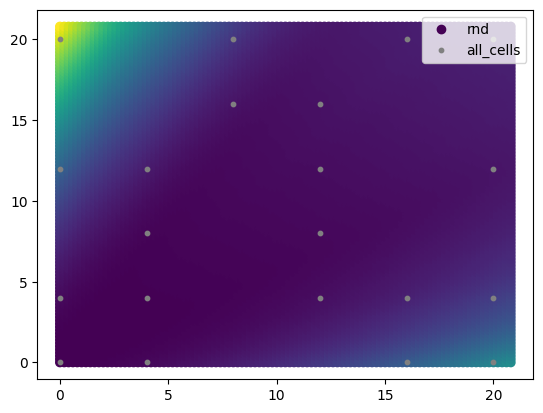

In [141]:
plot_data(data_to_plot)
# plt.colorbar()

In [142]:
print(f'max: {np.max(data_to_plot["rnd"]["c"])}')
print(f'min: {np.min(data_to_plot["rnd"]["c"])}')

max: 0.018338626250624657
min: 6.293776550592156e-06


In [143]:
from agents import agents
config['train_goal_proposer'] = False

In [144]:
agent_class = agents[config['agent_name']]
agent = agent_class.create(
    0,
    train_dataset.sample(1),
    config
)

In [145]:
agent

GCFQLAgent(rng=Array([1797259609, 2579123966], dtype=uint32), network=TrainState(step=1, apply_fn=<bound method Module.apply of ModuleDict(
    # attributes
    modules = {'critic': GCValue(
        # attributes
        hidden_dims = (512, 512, 512, 512)
        output_dim = None
        mlp_class = MLP
        layer_norm = True
        num_ensembles = 10
        gc_encoder = None
    ), 'target_critic': GCValue(
        # attributes
        hidden_dims = (512, 512, 512, 512)
        output_dim = None
        mlp_class = MLP
        layer_norm = True
        num_ensembles = 10
        gc_encoder = None
    ), 'actor_bc_flow': ActorVectorField(
        # attributes
        hidden_dims = (512, 512, 512, 512)
        action_dim = 21
        mlp_class = MLP
        activate_final = False
        layer_norm = True
        gc_encoder = None
    ), 'actor_onestep_flow': ActorVectorField(
        # attributes
        hidden_dims = (512, 512, 512, 512)
        action_dim = 21
        mlp_class 

In [146]:
from utils.flax_utils import restore_agent
agent = restore_agent(agent, '../../scratch/aorl/e2e_maze_6_2/e2e_maze_6_2.3f713d0acc3ef0743d38cd5572dfbcf21337cacb02c2671dfb7f437e6190dff6', 900000)

Restored from ../../scratch/aorl/e2e_maze_6_2/e2e_maze_6_2.3f713d0acc3ef0743d38cd5572dfbcf21337cacb02c2671dfb7f437e6190dff6/params_900000.pkl


This is an agent that has been trained for 900000 steps.